In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
#read features and labels
df_features = pd.read_csv('pretrain_features_new.csv')
train_features = pd.read_csv('train_features_new.csv')
test_features = pd.read_csv('test_features_new.csv')
df_labels = pd.read_csv('pretrain_labels.csv')

#store featues and labels in arrays
X = df_features.to_numpy()
train_features = train_features.to_numpy()
test_features = test_features.to_numpy()
y = df_labels["lumo_energy"].to_numpy()

#training test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#initilaize callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [3]:
#desing a model
pretrain_model = tf.keras.Sequential([
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(75, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu', name = 'second_last'),
    tf.keras.layers.Dense(50, activation='relu', name = 'last'),
    tf.keras.layers.Dense(1)
])

#compile a model
pretrain_model.compile(loss='mse',
                       optimizer=tf.keras.optimizers.Adam())

#train the model
history = pretrain_model.fit(X_train, y_train, epochs= 100, batch_size = 128,
                             validation_data=(X_test, y_test), callbacks=[callback])

Metal device set to: Apple M1 Pro
Epoch 1/100


2022-05-31 17:19:23.470006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-31 17:19:23.470110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-31 17:19:23.505583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-31 17:19:23.505780: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-31 17:19:23.665070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.1214

2022-05-31 17:19:25.627718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step - loss: 0.1214 - val_loss: 0.0365
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0321 - val_loss: 0.0308
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0271 - val_loss: 0.0262
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0243 - val_loss: 0.0186
Epoch 5/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0219 - val_loss: 0.0166
Epoch 6/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0180 - val_loss: 0.0157
Epoch 7/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0165 - val_loss: 0.0132
Epoch 8/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 9/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 10/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0133 - val_loss: 0.0122
E

2022-05-31 17:20:07.892669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


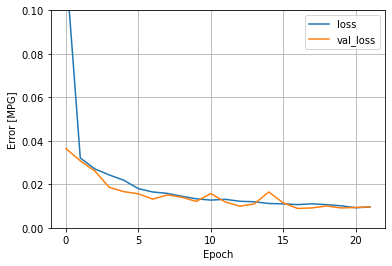

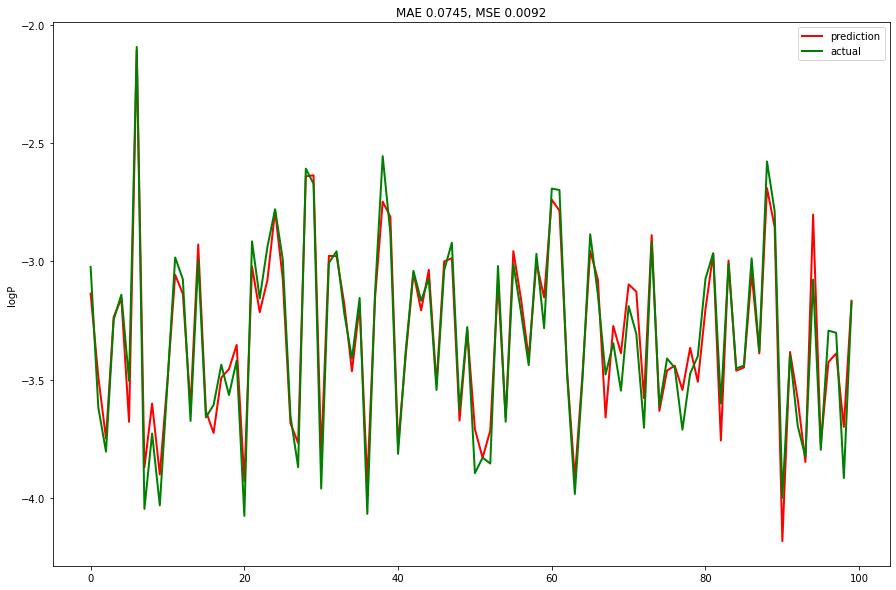

MAE score: 0.0745
MSE score: 0.0092


2022-05-31 17:20:10.045943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


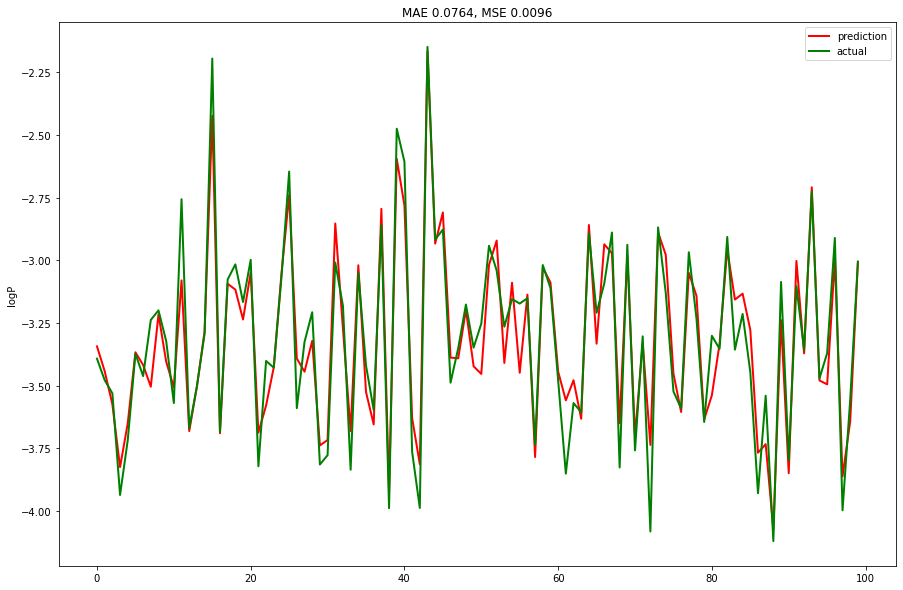

MAE score: 0.0764
MSE score: 0.0096


In [4]:
#visualize the performance of the model
def plot_loss(history):
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.plot(history.history['rmse'], label='rmse')
    #plt.plot(history.history['val_rmse'], label='val_rmse')
    plt.ylim([0,0.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:100], "red", label="prediction", linewidth=2.0)
    plt.plot(y_test[:100], 'green', label="actual", linewidth=2.0)
    plt.legend()
    plt.ylabel('logP')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse,4))
    
evaluation(pretrain_model, X_train, y_train)
evaluation(pretrain_model, X_test, y_test)

In [5]:
#preprocess the features of training and test set
layer_name = 'second_last'
new_model = Model(inputs=pretrain_model.input,
                                 outputs=pretrain_model.get_layer(layer_name).output)

train_processed = new_model.predict(train_features)
test_processed = new_model.predict(test_features)

df_train_processed = pd.DataFrame(train_processed)
df_test_processed = pd.DataFrame(test_processed)

df_test_processed.to_csv('processed_test_features.csv', index=False)
df_train_processed.to_csv('processed_train_features.csv', index=False)

2022-05-31 17:20:10.697360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
